Install the necessary packages

In [0]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install --upgrade tf-keras
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successful

In [1]:
!pip install alibi spacy_transformers
!pip install sentencepiece
!pip install imblearn

Import the necessary packages

In [2]:
import os
import spacy
import random
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, create_optimizer
from alibi.explainers import AnchorText

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Set the random seed for reproducibility

In [ ]:
# set seed, TF uses python ramdom and numpy library, so these must also be fixed
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED']=str(0)
os.environ['TF_DETERMINISTIC_OPS'] = '0'

In [12]:
df1 = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG1.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG2.xlsx')

In [ ]:
df1.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]


In [ ]:
df2.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


Preprocess the data, remove rows with no agreement and convert the labels to binary

In [13]:
df1 = df1[df1['label_bias']!='No agreement']
df1.replace(to_replace='Biased', value=1, inplace=True)
df1.replace(to_replace='Non-biased', value=0, inplace=True)

<ipython-input-13-63335be02dd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace(to_replace='Biased', value=1, inplace=True)
<ipython-input-13-63335be02dd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace(to_replace='Non-biased', value=0, inplace=True)


In [14]:
df2 = df2[df2['label_bias']!='No agreement']
df2.replace(to_replace='Biased', value=1, inplace=True)
df2.replace(to_replace='Non-biased', value=0, inplace=True)

<ipython-input-14-9b46a2d081cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace(to_replace='Biased', value=1, inplace=True)
<ipython-input-14-9b46a2d081cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace(to_replace='Non-biased', value=0, inplace=True)


Define the stratified k-fold instance

In [ ]:
# Stratified k-Fold instance
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Define the functions to be used in the skfold loop. These functions are used to convert the pandas dataframe into a tensorflow dataset, plot the training history, plot the confusion matrix, and tokenize the data for the transformer model.

In [7]:
# helper functions called in skfold loop

def pd_to_tf(df):
    """convert a pandas dataframe into a tensorflow dataset"""
    target = df.pop('label_bias')
    sentence = df.pop('text')
    return tf.data.Dataset.from_tensor_slices((sentence.values, target.values))

def plot_graphs(history, metric, filename):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.savefig(filename)
  plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, filename):
    """Plots a confusion matrix as a heatmap and saves it as a PNG file."""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    # Create a heatmap from the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)

    # Set labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    # Save the figure
    plt.savefig(filename)
    plt.show()

def tokenize(df):
    """convert a pandas dataframe into a tensorflow dataset and run hugging face's tokenizer on data"""
    target = df.pop('label_bias')
    sentence = df.pop('text')

    train_encodings = tokenizer(
                        sentence.tolist(),
                        add_special_tokens = True, # add [CLS], [SEP]
                        truncation = True, # cut off at max length of the text that can go to BERT
                        padding = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings),
         target.tolist()))
    return dataset



Define the function to run the model. This function takes in the training data, the name of the file, and the flags to freeze the encoder layer and use pretrained weights. It returns the validation loss, accuracy, precision, recall, f1 score, micro f1 score, and weighted macro f1 score. The run_model_5fold function is similar to the run_model function, but it uses a 5-fold cross-validation instead of a single validation set.

In [ ]:
def run_model(df_train, named_file, freeze_encoder=True, pretrained=False, plot=False):
  """"freeze flags whether encoder layer should be frozen to not destroy transfer learning. Only set to false when enough data is provided"""
#
  Y = df_train['label_bias']
  X = df_train['text']

  # hyperparams
  BUFFER_SIZE = 10000
  BATCH_SIZE = 16
  epochs = 40

  # Split the data into training and testing sets
  X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

  train_dataset = pd.concat([X_train, y_train], axis=1)
  val_dataset = pd.concat([X_val, y_val], axis=1)

  ros = RandomOverSampler(random_state=0)
  X_resampled, y_resampled = ros.fit_resample(pd.DataFrame(train_dataset['text']), pd.DataFrame(train_dataset['label_bias']))

  # Replace the original training dataset with the resampled dataset
  train_dataset = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
  train_dataset.columns = ['text', 'label_bias']
  # prepare data for transformer
  train_dataset = tokenize(train_dataset)
  val_dataset = tokenize(val_dataset)

  # mini-batch it
  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
  val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

  # create new model
  model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')

  if freeze_encoder == True:
    for w in model.get_layer(index=0).weights:
      w._trainable = False

  # compile it
  loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  optimizer, lr_schedule = create_optimizer(
  init_lr=2e-5, num_warmup_steps=0,
  num_train_steps=len(train_dataset) // BATCH_SIZE * epochs)
  model.compile(optimizer=optimizer, loss=loss_function)

  # transfer learning
  if pretrained == True:
    model.get_layer(index=0).set_weights(trained_model_layer) # load bias-specific weights

  # fit it
  history = model.fit(train_dataset, epochs=20, validation_data = val_dataset)

  # save the fine-tuned model
  model.save_weights(f'{named_file}_Roberta_fine_tuned.h5')

  # plot history
  if plot:
    plot_graphs(history,'loss', named_file+'_loss')
    #plot_graphs(history,'accuracy', named_file+'_accuracy')

  # evaluate
  loss = model.evaluate(val_dataset)

  logits = model.predict(val_dataset)
  yhats = []
  for i in logits[0]:
    # assign class label according to highest logit
    candidates = i.tolist()
    decision = candidates.index(max(candidates))
    yhats.append(decision)

  y = []
  for text, label in val_dataset.unbatch():
    y.append(label.numpy())

  # Plot and save the confusion matrix
  plot_confusion_matrix(y, yhats, ['Non-biased', 'Biased'], f'{named_file}_confusion_matrix.png')

  val_loss = loss
  val_acc = accuracy_score(y, yhats)
  val_prec = precision_score(y, yhats)
  val_rec = recall_score(y, yhats)
  val_f1 = f1_score(y, yhats)
  val_f1_micro = f1_score(y, yhats, average='micro')
  val_f1_wmacro = f1_score(y, yhats, average='weighted')

  tf.keras.backend.clear_session()

  return val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro


In [ ]:
def run_model_5fold(df_train, named_file, freeze_encoder=True, pretrained=False, plot=False):
  """"freeze flags whether encoder layer should be frozen to not destroy transfer learning. Only set to false when enough data is provided"""

  # these variables will be needed for skfold to select indices
  Y = df_train['label_bias']
  X = df_train['text']

  # hyperparams
  BUFFER_SIZE = 10000
  BATCH_SIZE = 32
  epochs = 40
  k = 1

  val_loss = []
  val_acc = []
  val_prec = []
  val_rec = []
  val_f1 = []
  val_f1_micro = []
  val_f1_wmacro = []


  for train_index, val_index in skfold.split(X,Y):
    print('### Start fold {}'.format(k))

    # split into train and validation set
    train_dataset = df_train.iloc[train_index]
    val_dataset = df_train.iloc[val_index]

    # Apply oversampling to the training dataset
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(pd.DataFrame(train_dataset['text']), pd.DataFrame(train_dataset['label_bias']))

    # Replace the original training dataset with the resampled dataset
    train_dataset = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
    train_dataset.columns = ['text', 'label_bias']
    # prepare data for transformer
    train_dataset = tokenize(train_dataset)
    val_dataset = tokenize(val_dataset)

    # mini-batch it
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    # create new model
    model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')


    if freeze_encoder == True:
      for w in model.get_layer(index=0).weights:
        w._trainable = False

    # compile it
    loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0,
    num_train_steps=len(train_dataset) // BATCH_SIZE * epochs)
    #optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer, loss=loss_function)

    # transfer learning
    if pretrained == True:
      model.get_layer(index=0).set_weights(trained_model_layer) # load bias-specific weights

    # after 2 epochs without improvement, stop training
    # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # fit it
    #history = model.fit(train_dataset, epochs=100, validation_data = val_dataset, callbacks=[callback])
    history = model.fit(train_dataset, epochs=30, validation_data = val_dataset)

    # checkpointing
    #checkpoint = ModelCheckpoint(f'{model_name}_fine_tuned_fold_{k}_epoch_{epoch:02d}.h5', save_weights_only=True)
    #history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, callbacks=[callback, checkpoint])


    # save the fine-tuned model
    model.save_weights(f'{named_file}_Roberta_fine_tuned_{k}.h5')

    # plot history
    if plot:
      plot_graphs(history,'loss', named_file+'_'+str(k)+'_fold_loss')
      #plot_graphs(history,'accuracy', named_file+'_'+str(k)+'_fold_accuracy')

    # evaluate
    loss = model.evaluate(val_dataset)

    logits = model.predict(val_dataset)
    yhats = []
    for i in logits[0]:
      # assign class label according to highest logit
      candidates = i.tolist()
      decision = candidates.index(max(candidates))
      yhats.append(decision)

    y = []
    for text, label in val_dataset.unbatch():
      y.append(label.numpy())

    # Plot and save the confusion matrix
    plot_confusion_matrix(y, yhats, ['Non-biased', 'Biased'], f'{named_file}_confusion_matrix_fold_{k}.png')

    val_loss.append(loss)
    val_acc.append(accuracy_score(y, yhats))
    val_prec.append(precision_score(y, yhats))
    val_rec.append(recall_score(y, yhats))
    val_f1.append(f1_score(y, yhats))
    val_f1_micro.append(f1_score(y, yhats, average='micro'))
    val_f1_wmacro.append(f1_score(y, yhats, average='weighted'))

    tf.keras.backend.clear_session()

    k += 1

  return val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro


Now run the model in two forms on SG1.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model(df1, named_file='df1',freeze_encoder=False, pretrained=False, plot=True)

print('Results for Roberta on SG1')
print('Validation Loss: {}'.format(val_loss))
print('Validation Accuracy: {}'.format(val_acc))
print('Validation Precision: {}'.format(val_prec))
print('Validation Recall: {}'.format(val_rec))
print('Validation F1 Score: {}'.format(val_f1))
print('Validation Micro F1 Score: {}'.format(val_f1_micro))
print('Validation Weighted Macro F1 Score: {}'.format(val_f1_wmacro))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

NameError: name 'run_model' is not defined

### Start fold 1


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
40/40 [==============================] - 141s 720ms/step - loss: 1.4861 - val_loss: 0.7458
Epoch 2/30
40/40 [==============================] - 14s 345ms/step - loss: 0.8040 - val_loss: 0.7458
Epoch 3/30
40/40 [==============================] - 13s 323ms/step - loss: 0.8006 - val_loss: 0.7458
Epoch 4/30
40/40 [==============================] - 13s 319ms/step - loss: 0.7903 - val_loss: 0.7458
Epoch 5/30
40/40 [==============================] - 12s 309ms/step - loss: 0.7903 - val_loss: 0.7458
Epoch 6/30
40/40 [==============================] - 12s 298ms/step - loss: 0.8023 - val_loss: 0.7458
Epoch 7/30
40/40 [==============================] - 12s 301ms/step - loss: 0.8096 - val_loss: 0.7458
Epoch 8/30
40/40 [==============================] - 12s 300ms/step - loss: 0.8083 - val_loss: 0.7458
Epoch 9/30
40/40 [==============================] - 12s 297ms/st

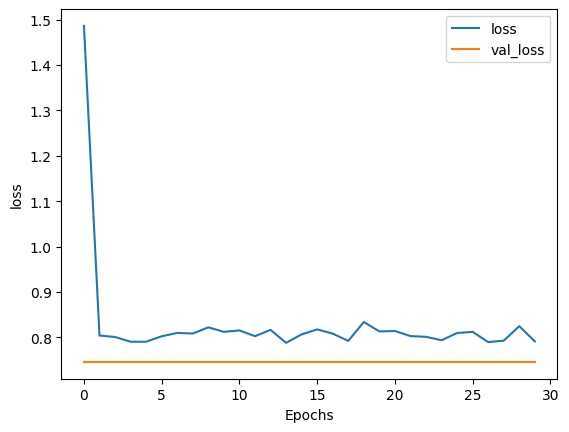

10/10 [==============================] - 12s 79ms/step


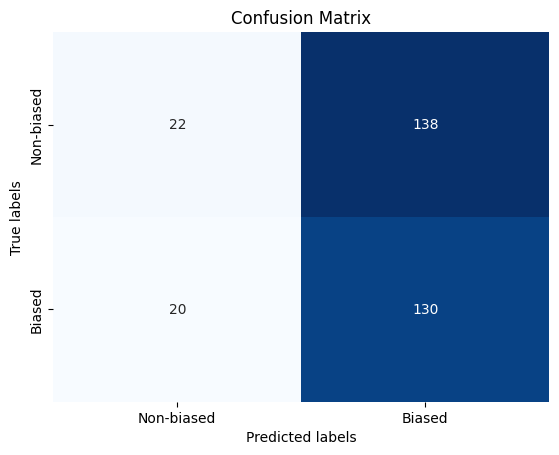

### Start fold 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 101s 708ms/step - loss: 0.9723 - val_loss: 0.6636
Epoch 2/30
40/40 [==============================] - 13s 329ms/step - loss: 0.7174 - val_loss: 0.6636
Epoch 3/30
40/40 [==============================] - 12s 313ms/step - loss: 0.7168 - val_loss: 0.6636
Epoch 4/30
40/40 [==============================] - 13s 312ms/step - loss: 0.7216 - val_loss: 0.6636
Epoch 5/30
40/40 [==============================] - 12s 310ms/step - loss: 0.7163 - val_loss: 0.6636
Epoch 6/30
40/40 [==============================] - 13s 317ms/step - loss: 0.7271 - val_loss: 0.6636
Epoch 7/30
40/40 [==============================] - 12s 310ms/step - loss: 0.7208 - val_loss: 0.6636
Epoch 8/30
40/40 [==============================] - 12s 307ms/step - loss: 0.7026 - val_loss: 0.6636
Epoch 9/30
40/40 [==============================] - 12s 297ms/step - loss: 0.7167 - val_loss: 0.6636
Epoch 10/30
40/40 [==============================] - 12s 303ms/step - loss: 0.7060 - val_l

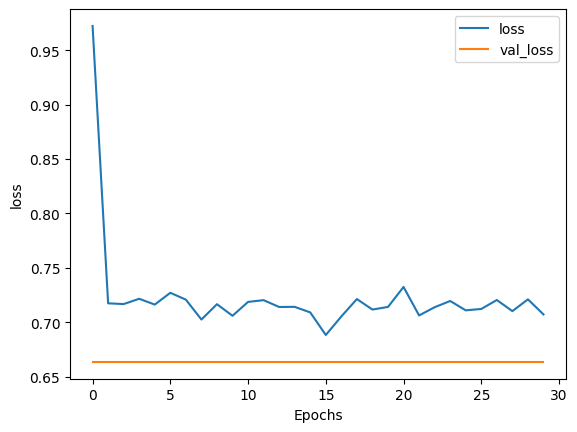

10/10 [==============================] - 12s 97ms/step


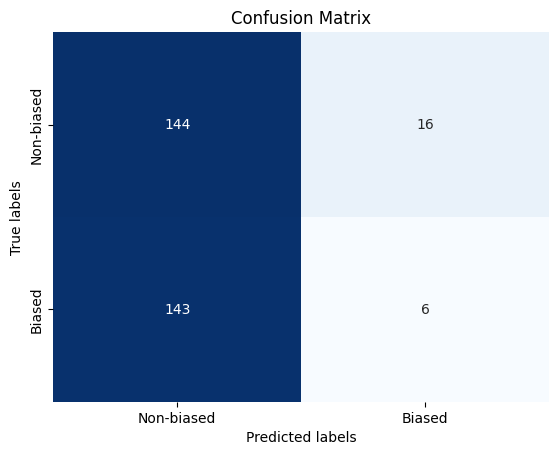

### Start fold 3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 103s 714ms/step - loss: 0.9482 - val_loss: 0.6306
Epoch 2/30
40/40 [==============================] - 13s 327ms/step - loss: 0.6593 - val_loss: 0.6306
Epoch 3/30
40/40 [==============================] - 13s 322ms/step - loss: 0.6499 - val_loss: 0.6306
Epoch 4/30
40/40 [==============================] - 13s 313ms/step - loss: 0.6549 - val_loss: 0.6306
Epoch 5/30
40/40 [==============================] - 12s 306ms/step - loss: 0.6510 - val_loss: 0.6306
Epoch 6/30
40/40 [==============================] - 12s 310ms/step - loss: 0.6468 - val_loss: 0.6306
Epoch 7/30
40/40 [==============================] - 13s 318ms/step - loss: 0.6592 - val_loss: 0.6306
Epoch 8/30
40/40 [==============================] - 12s 306ms/step - loss: 0.6521 - val_loss: 0.6306
Epoch 9/30
40/40 [==============================] - 12s 300ms/step - loss: 0.6474 - val_loss: 0.6306
Epoch 10/30
40/40 [==============================] - 12s 300ms/step - loss: 0.6548 - val_l

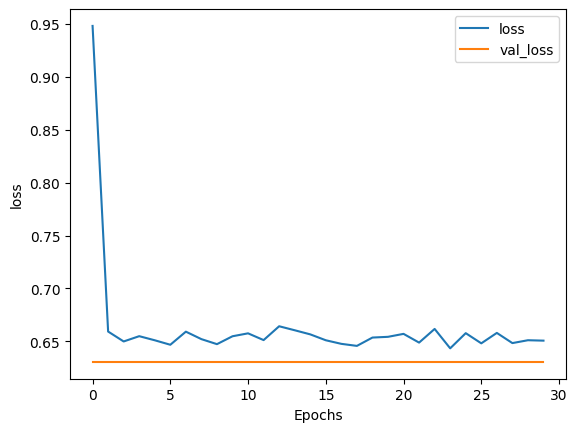

10/10 [==============================] - 11s 81ms/step


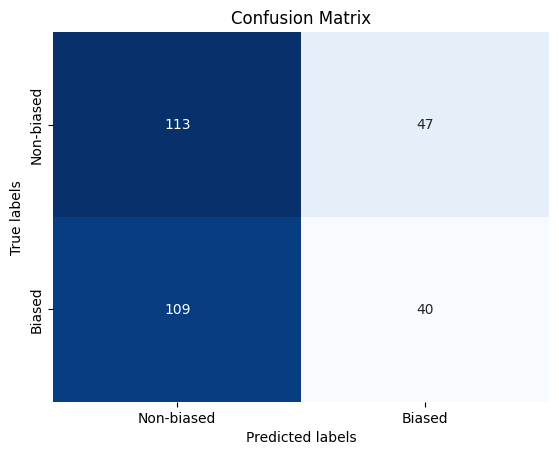

### Start fold 4


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 104s 721ms/step - loss: 0.7362 - val_loss: 0.6284
Epoch 2/30
40/40 [==============================] - 13s 333ms/step - loss: 0.6673 - val_loss: 0.6284
Epoch 3/30
40/40 [==============================] - 13s 321ms/step - loss: 0.6839 - val_loss: 0.6284
Epoch 4/30
40/40 [==============================] - 12s 309ms/step - loss: 0.6936 - val_loss: 0.6284
Epoch 5/30
40/40 [==============================] - 12s 311ms/step - loss: 0.6684 - val_loss: 0.6284
Epoch 6/30
40/40 [==============================] - 12s 302ms/step - loss: 0.6768 - val_loss: 0.6284
Epoch 7/30
40/40 [==============================] - 13s 316ms/step - loss: 0.6666 - val_loss: 0.6284
Epoch 8/30
40/40 [==============================] - 13s 315ms/step - loss: 0.6642 - val_loss: 0.6284
Epoch 9/30
40/40 [==============================] - 12s 297ms/step - loss: 0.6604 - val_loss: 0.6284
Epoch 10/30
40/40 [==============================] - 12s 294ms/step - loss: 0.6594 - val_l

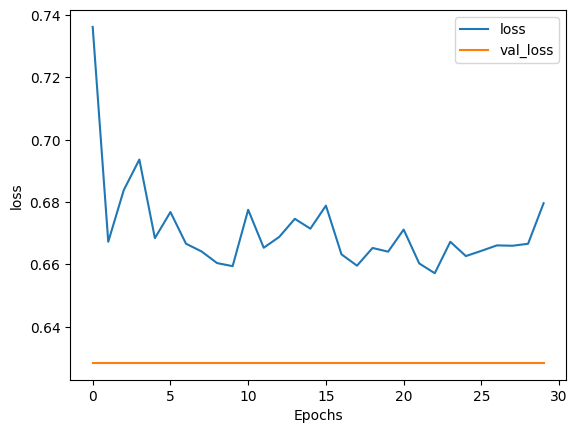

10/10 [==============================] - 11s 83ms/step


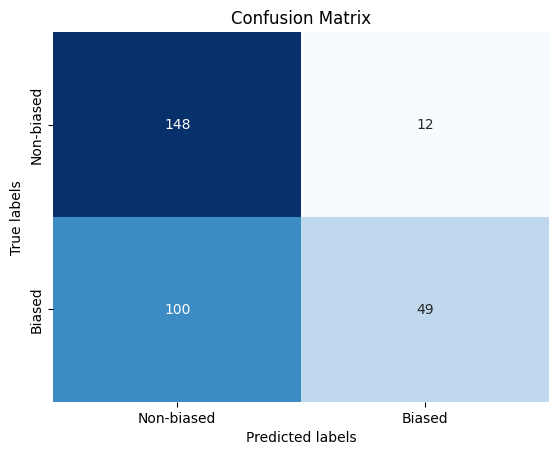

### Start fold 5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
40/40 [==============================] - 103s 720ms/step - loss: 2.2799 - val_loss: 0.6957
Epoch 2/30
40/40 [==============================] - 13s 329ms/step - loss: 0.7282 - val_loss: 0.6957
Epoch 3/30
40/40 [==============================] - 13s 319ms/step - loss: 0.7361 - val_loss: 0.6957
Epoch 4/30
40/40 [==============================] - 12s 313ms/step - loss: 0.7718 - val_loss: 0.6957
Epoch 5/30
40/40 [==============================] - 13s 312ms/step - loss: 0.7359 - val_loss: 0.6957
Epoch 6/30
40/40 [==============================] - 12s 304ms/step - loss: 0.7066 - val_loss: 0.6957
Epoch 7/30
40/40 [==============================] - 12s 303ms/step - loss: 0.7577 - val_loss: 0.6957
Epoch 8/30
40/40 [==============================] - 12s 301ms/step - loss: 0.7545 - val_loss: 0.6957
Epoch 9/30
40/40 [==============================] - 12s 307ms/step - loss: 0.7660 - val_loss: 0.6957
Epoch 10/30
40/40 [==============================] - 12s 305ms/step - loss: 0.7345 - val_l

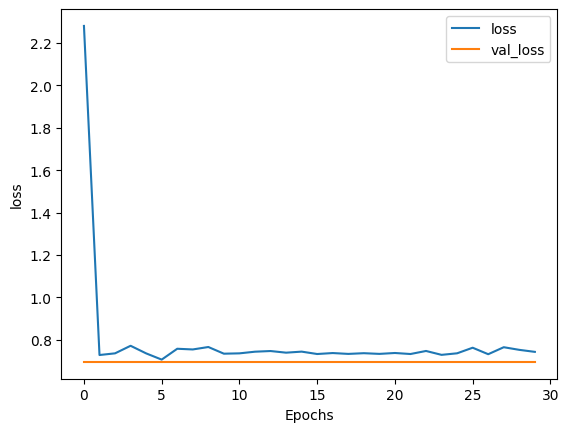

10/10 [==============================] - 12s 116ms/step


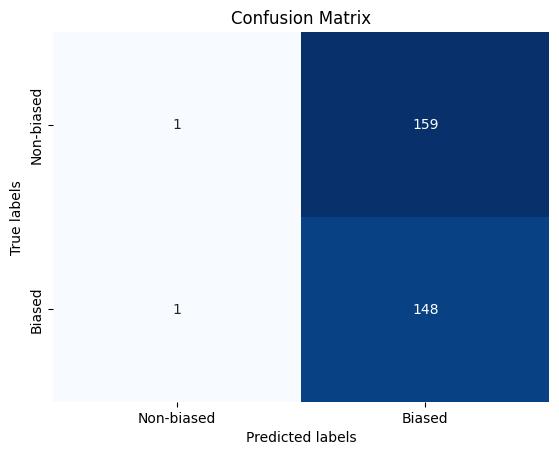

Results for Roberta on SG1
5-Fold CV Loss: 0.6728020310401917
5-Fold CV Accuracy: 0.5181292410481261
5-Fold CV Precision: 0.5005870787227618
5-Fold CV Recall: 0.49950782997762866
5-Fold CV F1 Score: 0.42939150650123
5-Fold CV Micro F1 Score: 0.5181292410481261
5-Fold CV Weighted Macro F1 Score: 0.4341472134264954


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df1, named_file='df1',freeze_encoder=False, pretrained=False, plot=True)
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('Results for Roberta on SG1')
print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Run the model similarily on SG2

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model(df2, named_file='df2',freeze_encoder=True, pretrained=False, plot=True)

print('Results for Roberta on SG1')
print('Validation Loss: {}'.format(val_loss))
print('Validation Accuracy: {}'.format(val_acc))
print('Validation Precision: {}'.format(val_prec))
print('Validation Recall: {}'.format(val_rec))
print('Validation F1 Score: {}'.format(val_f1))
print('Validation Micro F1 Score: {}'.format(val_f1_micro))
print('Validation Weighted Macro F1 Score: {}'.format(val_f1_wmacro))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

### Start fold 1


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
94/94 [==============================] - 147s 505ms/step - loss: 0.9063 - val_loss: 0.5411
Epoch 2/30
94/94 [==============================] - 30s 316ms/step - loss: 0.5906 - val_loss: 0.5411
Epoch 3/30
94/94 [==============================] - 29s 312ms/step - loss: 0.5882 - val_loss: 0.5411
Epoch 4/30
94/94 [==============================] - 28s 297ms/step - loss: 0.5936 - val_loss: 0.5411
Epoch 5/30
94/94 [==============================] - 28s 296ms/step - loss: 0.5892 - val_loss: 0.5411
Epoch 6/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5898 - val_loss: 0.5411
Epoch 7/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5902 - val_loss: 0.5411
Epoch 8/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5941 - val_loss: 0.5411
Epoch 9/30
94/94 [==============================] - 28s 295ms/st

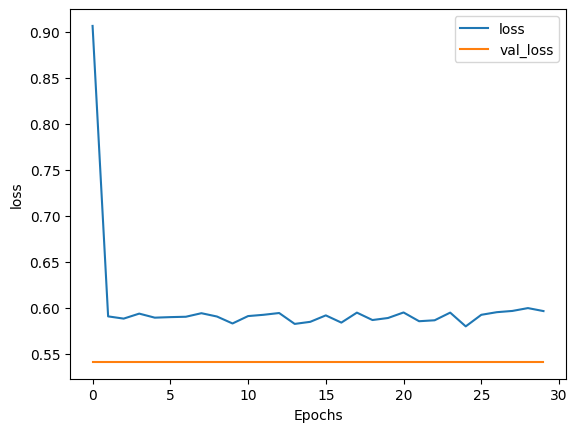

23/23 [==============================] - 11s 86ms/step


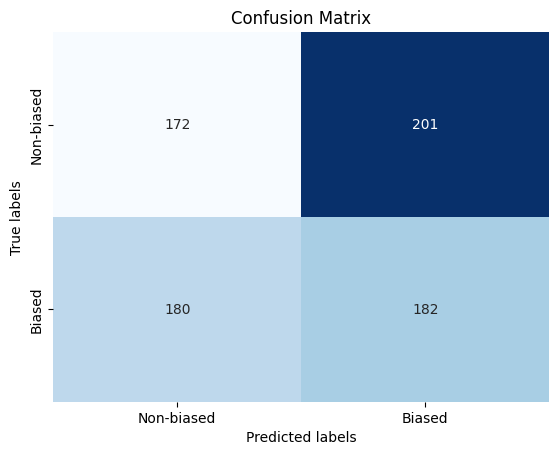

### Start fold 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 107s 460ms/step - loss: 0.7190 - val_loss: 0.5414
Epoch 2/30
94/94 [==============================] - 28s 299ms/step - loss: 0.5718 - val_loss: 0.5414
Epoch 3/30
94/94 [==============================] - 28s 298ms/step - loss: 0.5870 - val_loss: 0.5414
Epoch 4/30
94/94 [==============================] - 28s 293ms/step - loss: 0.5846 - val_loss: 0.5414
Epoch 5/30
94/94 [==============================] - 28s 298ms/step - loss: 0.5788 - val_loss: 0.5414
Epoch 6/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5795 - val_loss: 0.5414
Epoch 7/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5773 - val_loss: 0.5414
Epoch 8/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5706 - val_loss: 0.5414
Epoch 9/30
94/94 [==============================] - 27s 287ms/step - loss: 0.5895 - val_loss: 0.5414
Epoch 10/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5821 - val_l

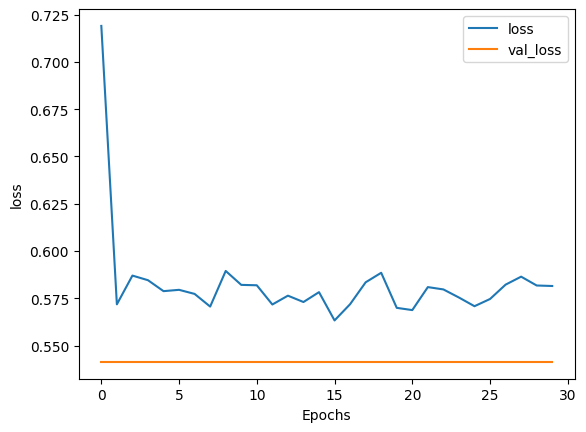

23/23 [==============================] - 11s 81ms/step


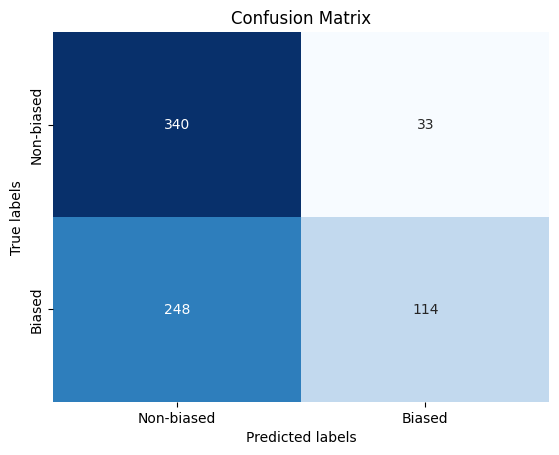

### Start fold 3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 108s 454ms/step - loss: 0.7381 - val_loss: 0.4885
Epoch 2/30
94/94 [==============================] - 28s 302ms/step - loss: 0.5388 - val_loss: 0.4885
Epoch 3/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5435 - val_loss: 0.4885
Epoch 4/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5544 - val_loss: 0.4885
Epoch 5/30
94/94 [==============================] - 27s 291ms/step - loss: 0.5571 - val_loss: 0.4885
Epoch 6/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5413 - val_loss: 0.4885
Epoch 7/30
94/94 [==============================] - 28s 295ms/step - loss: 0.5442 - val_loss: 0.4885
Epoch 8/30
94/94 [==============================] - 28s 297ms/step - loss: 0.5369 - val_loss: 0.4885
Epoch 9/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5522 - val_loss: 0.4885
Epoch 10/30
94/94 [==============================] - 27s 288ms/step - loss: 0.5331 - val_l

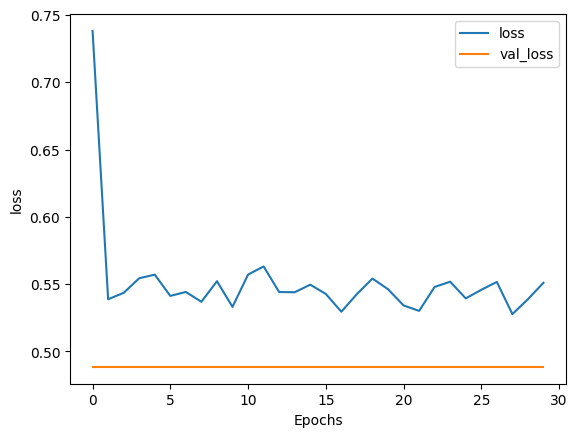

23/23 [==============================] - 10s 82ms/step


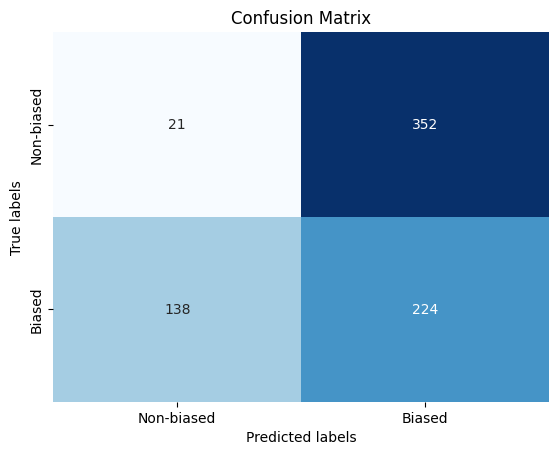

### Start fold 4


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 109s 462ms/step - loss: 0.6907 - val_loss: 0.5736
Epoch 2/30
94/94 [==============================] - 29s 309ms/step - loss: 0.5452 - val_loss: 0.5736
Epoch 3/30
94/94 [==============================] - 28s 298ms/step - loss: 0.5471 - val_loss: 0.5736
Epoch 4/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5468 - val_loss: 0.5736
Epoch 5/30
94/94 [==============================] - 27s 293ms/step - loss: 0.5396 - val_loss: 0.5736
Epoch 6/30
94/94 [==============================] - 27s 291ms/step - loss: 0.5463 - val_loss: 0.5736
Epoch 7/30
94/94 [==============================] - 27s 290ms/step - loss: 0.5496 - val_loss: 0.5736
Epoch 8/30
94/94 [==============================] - 27s 291ms/step - loss: 0.5483 - val_loss: 0.5736
Epoch 9/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5513 - val_loss: 0.5736
Epoch 10/30
94/94 [==============================] - 27s 292ms/step - loss: 0.5401 - val_l

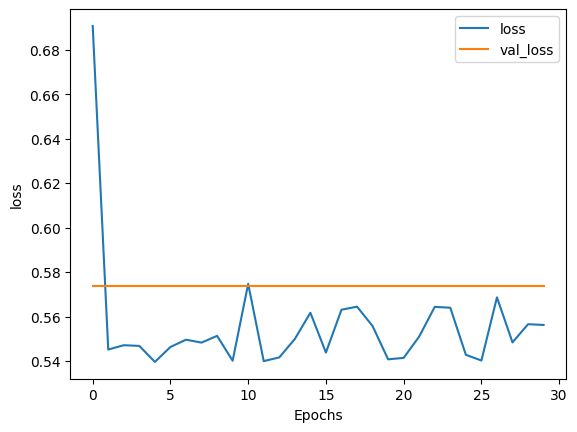

23/23 [==============================] - 12s 87ms/step


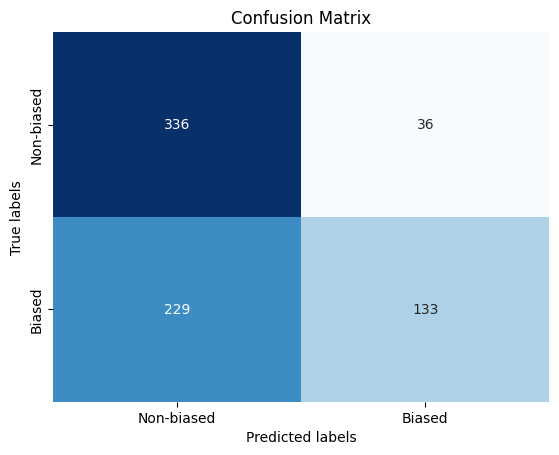

### Start fold 5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/30
94/94 [==============================] - 106s 459ms/step - loss: 1.2977 - val_loss: 0.5333
Epoch 2/30
94/94 [==============================] - 26s 280ms/step - loss: 0.5999 - val_loss: 0.5333
Epoch 3/30
94/94 [==============================] - 26s 273ms/step - loss: 0.5961 - val_loss: 0.5333
Epoch 4/30
94/94 [==============================] - 25s 271ms/step - loss: 0.6193 - val_loss: 0.5333
Epoch 5/30
94/94 [==============================] - 25s 271ms/step - loss: 0.5980 - val_loss: 0.5333
Epoch 6/30
94/94 [==============================] - 26s 272ms/step - loss: 0.6111 - val_loss: 0.5333
Epoch 7/30
94/94 [==============================] - 25s 268ms/step - loss: 0.6116 - val_loss: 0.5333
Epoch 8/30
94/94 [==============================] - 25s 266ms/step - loss: 0.6355 - val_loss: 0.5333
Epoch 9/30
94/94 [==============================] - 25s 266ms/step - loss: 0.6107 - val_loss: 0.5333
Epoch 10/30
94/94 [==============================] - 25s 267ms/step - loss: 0.5892 - val_l

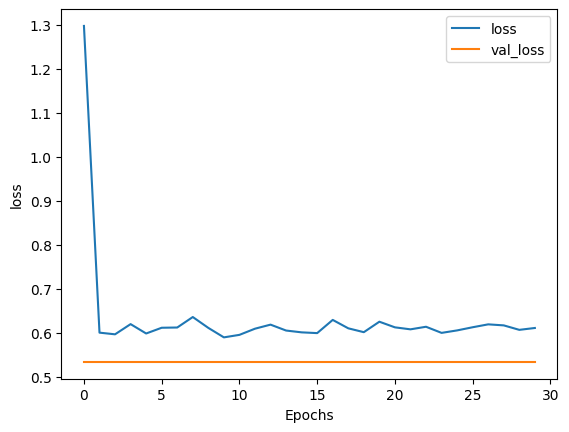

23/23 [==============================] - 12s 97ms/step


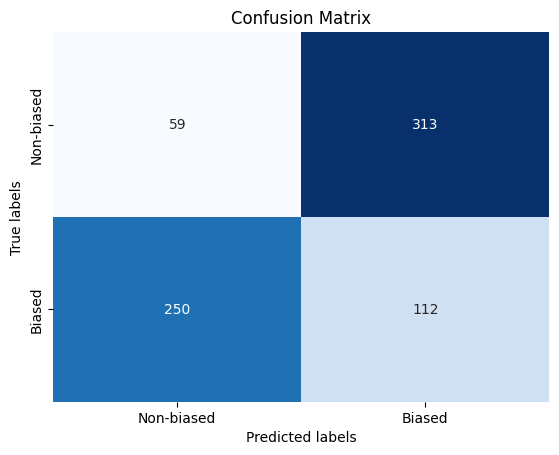

Results for Roberta on SG12
5-Fold CV Loss: 0.5355850219726562
5-Fold CV Accuracy: 0.46091753322582435
5-Fold CV Precision: 0.5380213151420492
5-Fold CV Recall: 0.42265193370165743
5-Fold CV F1 Score: 0.4399412908745385
5-Fold CV Micro F1 Score: 0.46091753322582435
5-Fold CV Weighted Macro F1 Score: 0.43503274607070874


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df2, named_file='df2',freeze_encoder=False, pretrained=False, plot=True)
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('Results for Roberta on SG12')
print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Applying Baseline functions to SG1 dataset

Majority Class Classifier Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       167
           1       0.00      0.00      0.00       143

    accuracy                           0.54       310
   macro avg       0.27      0.50      0.35       310
weighted avg       0.29      0.54      0.38       310


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


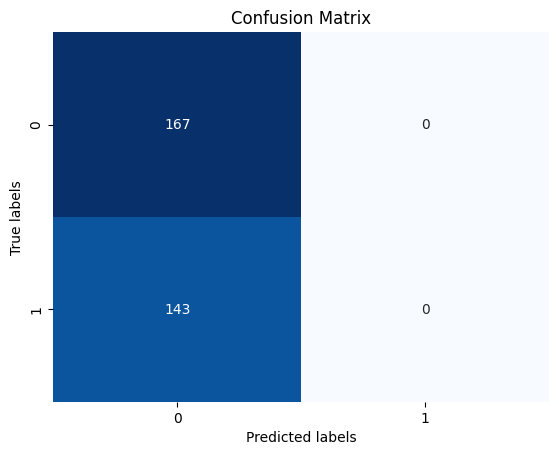

Random Guesser Report:
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       167
           1       0.44      0.50      0.47       143

    accuracy                           0.48       310
   macro avg       0.48      0.48      0.48       310
weighted avg       0.49      0.48      0.48       310


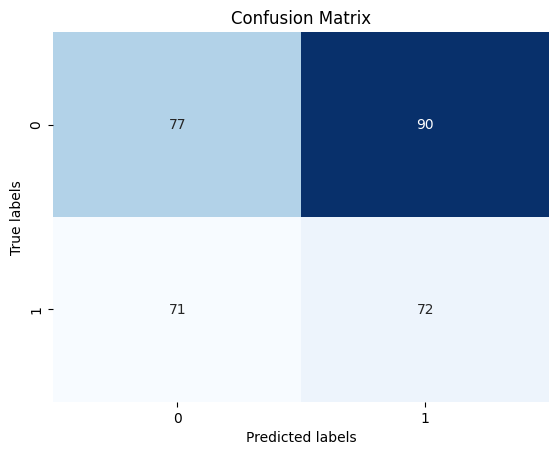

TF-IDF with Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       167
           1       0.64      0.61      0.62       143

    accuracy                           0.66       310
   macro avg       0.66      0.66      0.66       310
weighted avg       0.66      0.66      0.66       310


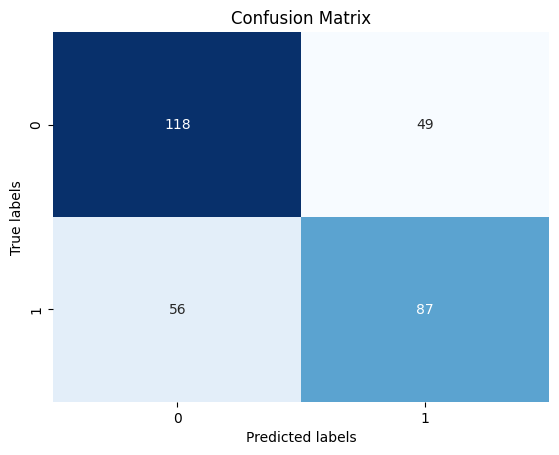

In [ ]:
# Assuming df is your DataFrame and "text" and "label_bias" are your columns
X = df1['text']
y = df1['label_bias']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Majority Class Classifier
majority_class_classifier = DummyClassifier(strategy='most_frequent')
majority_class_classifier.fit(X_train_tfidf, y_train)
y_pred = majority_class_classifier.predict(X_test_tfidf)
print("Majority Class Classifier Report:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='majority_class_classifier_cm_SG1.png')

# Random Guesser
random_guesser = DummyClassifier(strategy='uniform')
random_guesser.fit(X_train_tfidf, y_train)
y_pred = random_guesser.predict(X_test_tfidf)
print("Random Guesser Report:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='random_guesser_cm_SG1.png')

# TF-IDF with Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)
y_pred = logistic_regression.predict(X_test_tfidf)
print("TF-IDF with Logistic Regression Report:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='logistic_regression_cm_SG1.png')


Majority Class Classifier Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       376
           1       0.00      0.00      0.00       359

    accuracy                           0.51       735
   macro avg       0.26      0.50      0.34       735
weighted avg       0.26      0.51      0.35       735


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


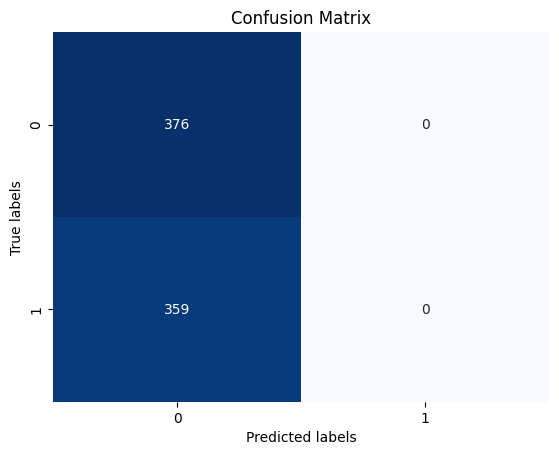

Random Guesser Report:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       376
           1       0.49      0.50      0.49       359

    accuracy                           0.50       735
   macro avg       0.50      0.50      0.50       735
weighted avg       0.50      0.50      0.50       735


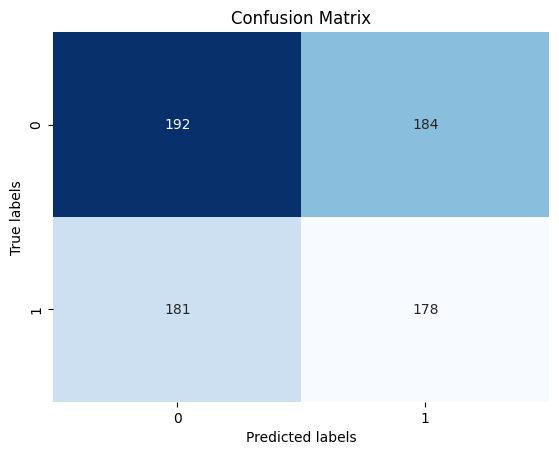

TF-IDF with Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       376
           1       0.73      0.75      0.74       359

    accuracy                           0.74       735
   macro avg       0.74      0.74      0.74       735
weighted avg       0.74      0.74      0.74       735


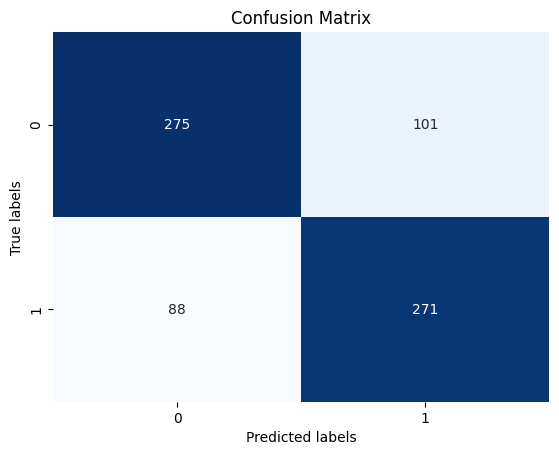

In [ ]:
# Assuming df is your DataFrame and "text" and "label_bias" are your columns
X = df2['text']
y = df2['label_bias']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Majority Class Classifier
majority_class_classifier = DummyClassifier(strategy='most_frequent')
majority_class_classifier.fit(X_train_tfidf, y_train)
y_pred = majority_class_classifier.predict(X_test_tfidf)
print("Majority Class Classifier Report:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='majority_class_classifier_cm_SG2.png')

# Random Guesser
random_guesser = DummyClassifier(strategy='uniform')
random_guesser.fit(X_train_tfidf, y_train)
y_pred = random_guesser.predict(X_test_tfidf)
print("Random Guesser Report:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='random_guesser_cm_SG2.png')

# TF-IDF with Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)
y_pred = logistic_regression.predict(X_test_tfidf)
print("TF-IDF with Logistic Regression Report:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y), filename='logistic_regression_cm_SG2.png')


The last step is the interpretation of the model's predictions using the AnchorText explainer from the Alibi library. The explainer generates an explanation for a given text by finding a set of words that are highly predictive of the model's prediction. The explanation is returned as a set of words (the anchor) and a precision score, which is the model's prediction accuracy when the anchor is present in the text. The precision score is a measure of the anchor's reliability, and a higher precision score indicates a more reliable anchor. The threshold parameter is used to control the precision score, and the explainer will return an anchor with a precision score greater than or equal to the threshold. 
The sampling_strategy parameter is used to control the sampling strategy for generating the anchor, and the nlp parameter is used to specify the spaCy model to be used for tokenization and similarity calculations. 
The following code demonstrates how to use the AnchorText explainer to generate an explanation for a given text.
The similarity sampling strategy is used to generate the anchor, and the en_core_web_md spaCy model is used for tokenization and similarity calculations.
The reasons for selecting the similarity sampling strategy:
1. Similarity Sampling uses corpus embeddings to generate samples that are contextually similar to the original text. This will likely maintain the semantic context of the original text, which leads to more meaningful explanations.
2. This can make the explanations easier to understand for users, as the anchors are more interpretable.

In [61]:
os.system('python -m spacy download en_core_web_md')
nlp = spacy.load('en_core_web_md')
df = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG2.xlsx')
def predict_fn(texts):
    predictions = []
    for text in texts:
        # Tokenize the text
        inputs = tokenizer(text, add_special_tokens=True, truncation=True, padding=True, return_attention_mask=True)
        # Convert the inputs to tensors and add a batch dimension
        input_ids = tf.convert_to_tensor([inputs['input_ids']])
        attention_mask = tf.convert_to_tensor([inputs['attention_mask']])
        # Get the prediction
        prediction = model(input_ids, attention_mask=attention_mask)[0]
        # Convert the prediction to probabilities
        probabilities = tf.nn.softmax(prediction, axis=1).numpy()[0]
        # Get the class with the highest probability
        predictions.append(np.argmax(probabilities))
    return np.array(predictions)


# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
model.load_weights(f'/content/drive/MyDrive/Models/df2_Roberta_fine_tuned_5.h5')

explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)
explanation = explainer.explain('The idea of a "rigged" economy that both benefits and is shaped by the rich and powerful was a popular theme in 2016 and is sure to play a big role again this cycle with several Democratic candidates emphasizing it on the campaign trail.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Anchor: 
Precision: 1.00


<ipython-input-61-672bfb6a8b34>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Precision: %.2f' % explanation.precision)


In [49]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
model.load_weights(f'/content/drive/MyDrive/Models/df2_Roberta_fine_tuned_4.h5')

# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Civil rights activists across the United States for years have called for scaling back traditional policing, and the efforts have gained momentum through protests over the death of George Floyd in Minneapolis police custody last month.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: efforts
Precision: 0.99


In [47]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
model.load_weights(f'/content/drive/MyDrive/Models/df2_Roberta_fine_tuned_4.h5')

# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('An attorney for President Donald Trump on Friday blasted U.S. House Democrats’ request for six years of Trump’s tax returns as “a misguided attempt” to politicize the tax laws, accusing lawmakers of harassment and interference in IRS audits.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: tax
Precision: 0.99


In [51]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
model.load_weights(f'/content/drive/MyDrive/Models/df2_Roberta_fine_tuned_3.h5')

# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('Japan has reported about 1300 deaths from COVID-19 but new cases in Tokyo have fallen in the last few weeks', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: reported
Precision: 0.98


In [53]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
model.load_weights(f'/content/drive/MyDrive/Models/df2_Roberta_fine_tuned_3.h5')

# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('The idea of a "rigged" economy that both benefits and is shaped by the rich and powerful was a popular theme in 2016 and is sure to play a big role again this cycle with several Democratic candidates emphasizing it on the campaign trail.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: play
Precision: 1.00


In [66]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
model.load_weights(f'/content/drive/MyDrive/Models/df2_Roberta_fine_tuned_2.h5')

# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('As you know, this is a very high priority for the president, ending surprise medical bills.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: bills
Precision: 1.00


In [55]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
model.load_weights(f'/content/drive/MyDrive/Models/df2_Roberta_fine_tuned_2.h5')

# Initialize the explainer
explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

# Generate explanation
explanation = explainer.explain('The findings suggest childhood vaccination efforts nearly ground to a halt between March 13 — when the national emergency was declared — and April 19.', threshold=0.95)

# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)

Anchor: efforts
Precision: 0.99


In [ ]:
!cp *.png "/content/drive/MyDrive/Models/"



Applying anchor prediction to the SG1 dataset(TODO)



In [ ]:
# Load spaCy model
#os.system('python -m spacy download en_core_web_md')
#nlp = spacy.load('en_core_web_md')
# Load the data
#df = pd.read_excel('/content/drive/MyDrive/Data_Sets/final_labels_SG1.xlsx')

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

for i in range(1, 6):
    # Load your fine-tuned Roberta model
    model = TFRobertaForSequenceClassification.from_pretrained('FacebookAI/roberta-base')
    model.load_weights(f'/content/drive/MyDrive/Models/df1_Roberta_fine_tuned_{i}.h5')

    def predict_fn(texts):
        predictions = []
        for text in texts:
            # Tokenize the text
            inputs = tokenizer.encode_plus(
                text,
                add_special_tokens=True,  # add [CLS], [SEP]
                truncation=True,  # cut off at max length of the text that can go to BERT
                padding='max_length',  # add [PAD] tokens
                max_length=512,  # maximum length for the text
                return_attention_mask=True,  # add attention mask to not focus on pad tokens
                return_tensors='tf'  # return TensorFlow tensors
            )
            # Get the prediction
            logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits.numpy()
            prediction = softmax(logits)
            predictions.append(prediction)
        return np.array(predictions)

    # Initialize anchor text explainer
    explainer = AnchorText(predictor=predict_fn, sampling_strategy='similarity', nlp=nlp)

    # Initialize empty lists to store the anchors, precisions, and coverages
    anchors = []
    precisions = []
    coverages = []

    # Iterate over the texts in your dataset
    for text in df['text']:
        # Generate explanation
        explanation = explainer.explain(text, threshold=0.95)
        # Append the anchor, precision, and coverage to the lists
        anchors.append(' AND '.join(explanation.anchor))
        precisions.append(explanation.precision)
        #coverages.append(explanation.coverage)

    # Add the anchors, precisions, and coverages as new columns to your dataframe
    df[f'anchors_f{i}'] = anchors
    df[f'precisions_f{i}'] = precisions
    #df[f'coverages_f{i}'] = coverages

# Save the dataframe to a new csv file
df.to_csv('final_labels_SG1_with_explanations.csv', index=False)


In [ ]:
!cp *.csv "/content/drive/MyDrive/Models/Results/"